In [49]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import matplotlib.pyplot as plt


In [50]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
BATCH1_PATH = "/content/drive/MyDrive/planet_batches/batch_0.npz"
BATCH2_PATH = "/content/drive/MyDrive/planet_batches/batch_1.npz"

KEY = "X"  # change if your npz uses a different name

In [52]:
batch1 = np.load(BATCH1_PATH)[KEY]
batch2 = np.load(BATCH2_PATH)[KEY]

print("Batch 1:", batch1.shape)
print("Batch 2:", batch2.shape)

Batch 1: (4, 1)
Batch 2: (4, 1)


In [53]:
print(f"Keys in batch_0.npz: {np.load(BATCH1_PATH).files}")
print(f"Keys in batch_1.npz: {np.load(BATCH2_PATH).files}")

Keys in batch_0.npz: ['X', 'y']
Keys in batch_1.npz: ['X', 'y']


In [54]:
X = np.concatenate([batch1.flatten(), batch2.flatten()], axis=0).reshape(1, -1).astype(np.float32)
print("Total planet light curves:", X.shape)

Total planet light curves: (1, 8)


In [55]:
SAVE_PATH = "/content/drive/MyDrive/exoplanet_data/exoplanet_data.npy"
np.save(SAVE_PATH, X)

In [56]:
class PlanetLightCurveDataset(Dataset):
    def __init__(self, npy_path):
        self.data = np.load(npy_path).astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]          # (L,)
        return torch.from_numpy(x).unsqueeze(0)  # (1, L)


In [57]:
dataset = PlanetLightCurveDataset(SAVE_PATH)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [58]:
sample = dataset[0]
print(sample.shape)  # Should now be (1, 8)

torch.Size([1, 8])


In [59]:
class PlanetAutoencoder(nn.Module):
    def __init__(self, input_length):
        super().__init__()

        # Encoder learns transit morphology
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 7, stride=2, padding=3),
            nn.ReLU(),

            nn.Conv1d(16, 32, 7, stride=2, padding=3),
            nn.ReLU(),

            nn.Conv1d(32, 64, 7, stride=2, padding=3),
            nn.ReLU()
        )

        # Decoder reconstructs planet light curves
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 7, stride=2, padding=3, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose1d(32, 16, 7, stride=2, padding=3, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose1d(16, 1, 7, stride=2, padding=3, output_padding=1)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"

input_length = dataset[0].shape[-1]
model = PlanetAutoencoder(input_length).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [61]:
class PlanetAutoencoder(nn.Module):
    def __init__(self, input_length):
        super().__init__()

        # Encoder learns transit morphology
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 7, stride=2, padding=3),
            nn.ReLU(),

            nn.Conv1d(16, 32, 7, stride=2, padding=3),
            nn.ReLU(),

            nn.Conv1d(32, 64, 7, stride=2, padding=3),
            nn.ReLU()
        )

        # Decoder reconstructs planet light curves
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 7, stride=2, padding=3, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose1d(32, 16, 7, stride=2, padding=3, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose1d(16, 1, 7, stride=2, padding=3, output_padding=1)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"

input_length = dataset[0].shape[-1] # This will now be 8
model = PlanetAutoencoder(input_length).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [63]:
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{EPOCHS}]  Reconstruction Loss: {avg_loss:.6f}")

Epoch [1/50]  Reconstruction Loss: 0.753870
Epoch [2/50]  Reconstruction Loss: 0.738591
Epoch [3/50]  Reconstruction Loss: 0.723355
Epoch [4/50]  Reconstruction Loss: 0.708067
Epoch [5/50]  Reconstruction Loss: 0.692620
Epoch [6/50]  Reconstruction Loss: 0.676825
Epoch [7/50]  Reconstruction Loss: 0.660627
Epoch [8/50]  Reconstruction Loss: 0.643760
Epoch [9/50]  Reconstruction Loss: 0.625974
Epoch [10/50]  Reconstruction Loss: 0.607100
Epoch [11/50]  Reconstruction Loss: 0.587190
Epoch [12/50]  Reconstruction Loss: 0.567481
Epoch [13/50]  Reconstruction Loss: 0.548541
Epoch [14/50]  Reconstruction Loss: 0.529763
Epoch [15/50]  Reconstruction Loss: 0.513969
Epoch [16/50]  Reconstruction Loss: 0.498780
Epoch [17/50]  Reconstruction Loss: 0.481904
Epoch [18/50]  Reconstruction Loss: 0.463655
Epoch [19/50]  Reconstruction Loss: 0.444427
Epoch [20/50]  Reconstruction Loss: 0.422989
Epoch [21/50]  Reconstruction Loss: 0.399704
Epoch [22/50]  Reconstruction Loss: 0.374684
Epoch [23/50]  Reco

In [64]:
def planet_reconstruction_error(model, x):
    model.eval()
    with torch.no_grad():
        recon = model(x)
        error = torch.mean((x - recon) ** 2, dim=[1, 2])
    return error


In [65]:
sample = dataset[0].unsqueeze(0).to(device)
error = planet_reconstruction_error(model, sample)
print("Planet reconstruction error:", error.item())

Planet reconstruction error: 0.014139262959361076


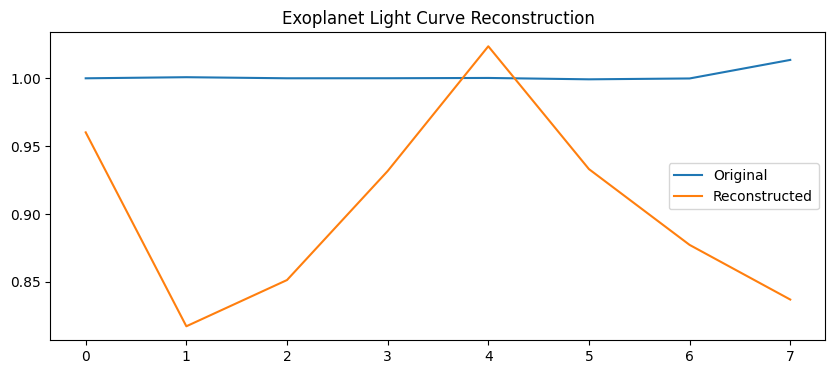

In [66]:
model.eval()
with torch.no_grad():
    recon = model(sample).cpu().squeeze().numpy()
    original = sample.cpu().squeeze().numpy()

plt.figure(figsize=(10,4))
plt.plot(original, label="Original")
plt.plot(recon, label="Reconstructed")
plt.legend()
plt.title("Exoplanet Light Curve Reconstruction")
plt.show()

In [67]:
MODEL_PATH = "/content/drive/MyDrive/exoplanet_data/planet_autoencoder.pt"
torch.save(model.state_dict(), MODEL_PATH)

The plot above shows two curves:

*   **Original**: This curve represents the actual, raw light curve data for an exoplanet. It shows how the planet's brightness changes over time, often exhibiting dips (transits) when a planet passes in front of its star.
*   **Reconstructed**: This curve is the output from the autoencoder model. It's the model's attempt to reconstruct the original light curve after passing it through its encoder and decoder layers. The closer the reconstructed curve is to the original, the better the autoencoder has learned the underlying patterns and features of the light curve.

In [69]:
MODEL_PATH = "/content/drive/MyDrive/exoplanet_data/planet_autoencoder.pt"
torch.save(model.state_dict(), MODEL_PATH)